# Make an MTH5 from NIMS data

This notebook provides an example of how to read in NIMS (.BIN) files into an MTH5. NIMS files represent a single run.   

In [ ]:
from mth5.mth5 import MTH5
from mth5.io.nims import NIMSCollection
from mth5 import read_file
from mth5_test_data import get_test_data_path

nims_data_path = get_test_data_path("nims")

### NIMS Collection

We will use the `NIMSCollection` to assemble the *.bin* files into a logical order by run. The output NIMS files include all data for each channel for a single run. Therefore the collection is relatively simple.

*Metadata:* we need to input the `survey_id` to provide minimal metadata when making an MTH5 file. 

The `NIMSCollection.get_runs()` will return a two level ordered dictionary (`OrderedDict`).  The first level is keyed by station ID.  These objects are in turn ordered dictionaries by run ID.  Therefore you can loop over stations and runs.  

**Note**: `n_samples` and `end` are estimates based on file size not the data.  To get an accurate number you should read in the full file. 

In [2]:
nc = NIMSCollection(nims_data_path)
nc.survey_id = "test"
runs = nc.get_runs(sample_rates=[8])
print(f"Found {len(runs)} station with {len(runs[list(runs.keys())[0]])} runs")

2026-01-04T12:14:56.324467-0800 | WARNING | mth5.io.nims.nims | end_time | line: 364 | Estimating end time from n_samples
2026-01-04T12:14:56.327468-0800 | WARNING | mth5.io.nims.nims | end_time | line: 364 | Estimating end time from n_samples
Found 2 station with 1 runs


In [3]:
for run_id, run_df in runs["300"].items():
    display(run_df)

,survey,station,run,start,end,channel_id,component,fn,sample_rate,file_size,n_samples,sequence_number,dipole,coil_number,latitude,longitude,elevation,instrument_id,calibration_fn
0,test,300,300b,2019-10-01 16:16:42+00:00,2019-10-03 22:55:52+00:00,1,"hx,hy,hz,ex,ey,temperature",C:\Users\peaco\OneDrive\Documents\GitHub\mth5_...,8,25774311,1574003,1,"[106.0, 109.0]",None,None,None,None,NIMS,None


## Build MTH5

Now that we have a logical collection of files, lets load them into an MTH5.  We will simply loop of the stations, runs, and channels in the ordered dictionary.

There are a few things that to keep in mind:  

- The LEMI raw files come with very little metadata, so as a user you will have to manually input most of it. 
- The output files from a LEMI are already calibrated into units of nT and mV/km (I think), therefore there are no filter to apply to calibrate the data. 
- Since this is a MTH5 file version 0.2.0 the filters are in the `survey_group` so add them there.

**TODO**:

    - make sure filters get propagated throught to mth5
    - think about run names

In [5]:
nims_mth5_path = nc.file_path.joinpath("from_nims.h5")

In [ ]:
%%time

calibrate = True
with MTH5() as m:
    if calibrate:
        m.data_level = 2
    m.open_mth5(nims_mth5_path)
    
    survey_group = m.add_survey(nc.survey_id)

    for station_id in runs.keys():
        station_group = survey_group.stations_group.add_station(station_id)
    
        for run_id, run_df in runs[station_id].items():
            run_group = station_group.add_run(run_id)
            run_ts = read_file(run_df.fn.unique()[0])
            if calibrate:
                run_ts = run_ts.calibrate()
            run_group.from_runts(run_ts)
        station_group.metadata.update(run_ts.station_metadata)
        station_group.write_metadata()
        
        station_group.update_metadata()
    survey_group.update_metadata()

2026-01-04T12:15:00.535333-0800 | INFO | mth5.mth5 | _initialize_file | line: 678 | Initialized MTH5 0.2.0 file C:\Users\peaco\OneDrive\Documents\GitHub\mth5_test_data\mth5_test_data\nims\from_nims.h5 in mode a
2026-01-04T12:15:08.452761-0800 | WARNING | mth5.timeseries.channel_ts | get_calibration_operation | line: 1162 | cannot determine multiply or divide via units -- setting to divide
2026-01-04T12:15:08.819392-0800 | WARNING | mt_metadata.timeseries.filters.channel_response | complex_response | line: 381 | No filters associated with <class 'mt_metadata.timeseries.filters.channel_response.ChannelResponse'>, returning 1
2026-01-04T12:15:09.045966-0800 | CRITICAL | mth5.timeseries.channel_ts | get_calibrated_units | line: 1198 | channel response filter units are likely corrupt or channel_ts has no units
2026-01-04T12:15:12.561375-0800 | WARNING | mth5.io.nims.nims | read_nims | line: 1240 | odd number of bytes 54971209, not even blocks cutting down the data by 72 bits
2026-01-04T12:1

#### MTH5 Structure

Have a look at the MTH5 structure and make sure it looks correct.

In [7]:
with MTH5() as m:
    m = m.open_mth5(nims_mth5_path)
    print(m)

    channel_df = m.channel_summary.to_dataframe()
    run_df = m.run_summary

/:
    |- Group: Experiment
    --------------------
        |- Group: Reports
        -----------------
        |- Group: Standards
        -------------------
            --> Dataset: summary
            ......................
        |- Group: Surveys
        -----------------
            |- Group: test
            --------------
                |- Group: Filters
                -----------------
                    |- Group: coefficient
                    ---------------------
                        |- Group: dipole_101.00
                        -----------------------
                        |- Group: dipole_106.00
                        -----------------------
                        |- Group: dipole_109.00
                        -----------------------
                        |- Group: e_analog_to_digital
                        -----------------------------
                        |- Group: h_analog_to_digital
                        -----------------------------
         

### Channel Summary

Have a look at the channel summary and make sure everything looks good.

In [8]:
channel_df

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,has_data,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,test,300,300b,34.726823,-115.735015,940.0,ex,2019-10-01 16:22:01+00:00,2019-10-03 23:01:03.875000+00:00,1573944,8.0,electric,0.0,0.0,milliVolt per kilometer,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,test,300,300b,34.726823,-115.735015,940.0,ey,2019-10-01 16:22:01+00:00,2019-10-03 23:01:03.875000+00:00,1573944,8.0,electric,90.0,0.0,milliVolt per kilometer,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,test,300,300b,34.726823,-115.735015,940.0,hx,2019-10-01 16:22:01+00:00,2019-10-03 23:01:03.875000+00:00,1573944,8.0,magnetic,0.0,0.0,nanoTesla,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,test,300,300b,34.726823,-115.735015,940.0,hy,2019-10-01 16:22:01+00:00,2019-10-03 23:01:03.875000+00:00,1573944,8.0,magnetic,90.0,0.0,nanoTesla,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,test,300,300b,34.726823,-115.735015,940.0,hz,2019-10-01 16:22:01+00:00,2019-10-03 23:01:03.875000+00:00,1573944,8.0,magnetic,0.0,0.0,nanoTesla,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
5,test,300,300b,34.726823,-115.735015,940.0,temperature,2019-10-01 16:22:01+00:00,2019-10-03 23:01:03.875000+00:00,1573944,8.0,auxiliary,0.0,0.0,unknown,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
6,test,Mnp300,Mnp300a,34.726827,-115.735012,940.4,ex,2019-09-26 18:33:21+00:00,2019-10-01 15:07:07.875000+00:00,3357016,8.0,electric,0.0,0.0,milliVolt per kilometer,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
7,test,Mnp300,Mnp300a,34.726827,-115.735012,940.4,ey,2019-09-26 18:33:21+00:00,2019-10-01 15:07:07.875000+00:00,3357016,8.0,electric,90.0,0.0,milliVolt per kilometer,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
8,test,Mnp300,Mnp300a,34.726827,-115.735012,940.4,hx,2019-09-26 18:33:21+00:00,2019-10-01 15:07:07.875000+00:00,3357016,8.0,magnetic,0.0,0.0,nanoTesla,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
9,test,Mnp300,Mnp300a,34.726827,-115.735012,940.4,hy,2019-09-26 18:33:21+00:00,2019-10-01 15:07:07.875000+00:00,3357016,8.0,magnetic,90.0,0.0,nanoTesla,True,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


## Run Summary

In [9]:
run_df

,channel_scale_factors,duration,end,has_data,input_channels,mth5_path,n_samples,output_channels,run,sample_rate,start,station,survey,run_hdf5_reference,station_hdf5_reference
0,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",196742.875,2019-10-03 23:01:03.875000+00:00,True,"[hx, hy]",C:/Users/peaco/OneDrive/Documents/GitHub/mth5_...,1573944,"[ex, ey, hz]",300b,8.0,2019-10-01 16:22:01+00:00,300,test,<HDF5 object reference>,<HDF5 object reference>
1,"{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",419626.875,2019-10-01 15:07:07.875000+00:00,True,"[hx, hy]",C:/Users/peaco/OneDrive/Documents/GitHub/mth5_...,3357016,"[ex, ey, hz]",Mnp300a,8.0,2019-09-26 18:33:21+00:00,Mnp300,test,<HDF5 object reference>,<HDF5 object reference>


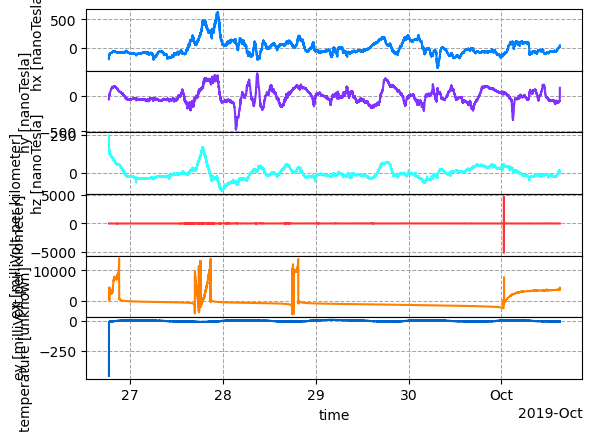

In [11]:
ts_plot = run_ts.plot()

C:\Users\peaco\OneDrive\Documents\GitHub\mth5\mth5\timeseries\run_ts.py:2196: RuntimeWarning: divide by zero encountered in divide
  (l1,) = ax.loglog(1.0 / plot_freq, power, lw=1.5, color=color_map[comp])


KeyError: 'temperature'

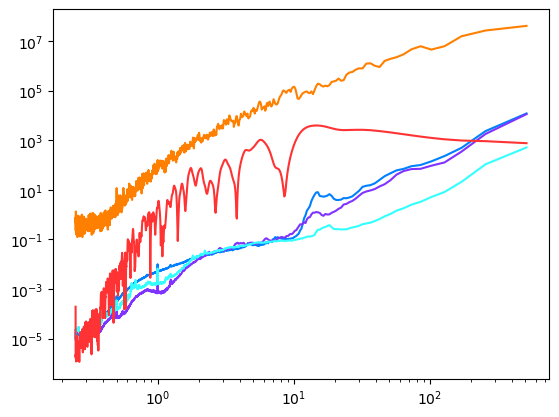

In [12]:
spectrum_plot = run_ts.plot_spectra()